# There should be 5 graphs in this notebook:
1. A graph showing the normalized average number of kinks as a function of the steps.
2. A graph showing the normalized variance of the number of kinks as a function of the steps.
3. A graph showing the ratio between the variance and the average number of kinks as a function of the noise.
4. A graphs showing the deference between the independent modes and the qiskit as a function of the circuits - with multiple lines of different number of shots.
5. A graphs showing the deference between the independent modes and the qiskit with some built in fake noises as a function of the circuits - with multiple lines of different number of shots.

## Imports

In [1]:
from collections import defaultdict
from typing import List, Optional

import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from tqdm import tqdm
import pickle

from discrete_numeric import get_dated_plot_path, tfim_momentum_trotter_single_k, count_kinks, process_step
from functions import k_f, pyplot_settings
from qiskit_ibm_runtime.fake_provider import FakeMarrakesh
from qiskit_ibm_runtime.sampler import SamplerV2

## Data Collection Functions

In [112]:
def calculate_graph1_2_data(g1_2_params, filename):
    """Calculates data for Graph 1 and 2 and saves it to a file."""
    ks = k_f(g1_2_params['num_qubits'])
    g1_2_results = defaultdict(dict)

    for noise_param in tqdm(g1_2_params['noise_params_list'], desc="Noise (G1, G2)"):
        for steps in tqdm(g1_2_params['steps_list'], desc="Steps", leave=False):
            base_angles = (np.pi / 2) * np.arange(1, steps + 1) / (steps + 1)
            base_angles = base_angles[:, np.newaxis]
            momentum_dms, qiskit_circs = [], []
            for _ in range(g1_2_params['num_circuits']):
                noisy_base = base_angles + noise_param * np.random.randn(steps, 1)
                betas, alphas = -np.sin(noisy_base).flatten(), -np.cos(noisy_base).flatten()
                sol = [tfim_momentum_trotter_single_k(k, steps, betas, alphas, 0) for k in ks]
                momentum_dms.append(sol)
                circuit = QuantumCircuit(g1_2_params['num_qubits'], g1_2_params['num_qubits'])
                circuit.h(range(g1_2_params['num_qubits']))
                for step in range(steps):
                    for i in range(0, g1_2_params['num_qubits'], 2): circuit.rzz(betas[step], i, (i + 1) % g1_2_params['num_qubits'])
                    for i in range(1, g1_2_params['num_qubits'], 2): circuit.rzz(betas[step], i, (i + 1) % g1_2_params['num_qubits'])
                    circuit.rx(alphas[step], range(g1_2_params['num_qubits']))
                circuit.measure(range(g1_2_params['num_qubits']), range(g1_2_params['num_qubits']))
                qiskit_circs.append(circuit)

            # Momentum model calculation (once per data point)
            mean_i, var_i = process_step(step_density_matrices=momentum_dms, ks=ks, num_qubits=g1_2_params['num_qubits'], method="rho")

            # Qiskit calculation with per-shot statistics
            simulator = AerSimulator()
            transpiled_circuits = transpile(qiskit_circs, simulator)
            job_result = simulator.run(transpiled_circuits, shots=g1_2_params['num_shots'], memory=True).result()

            # Create a matrix of kink counts: (num_circuits, num_shots)
            kink_counts_matrix = np.zeros((len(qiskit_circs), g1_2_params['num_shots']))
            for i in range(len(qiskit_circs)):
                outcomes = job_result.get_memory(i)
                kink_counts_matrix[i, :] = [count_kinks(state) for state in outcomes]

            # Calculate stats for each shot index across all circuits
            means_per_shot = []
            vars_per_shot = []
            for j in range(g1_2_params['num_shots']):
                kinks_for_shot_j = kink_counts_matrix[:, j]
                means_per_shot.append(np.mean(kinks_for_shot_j))
                vars_per_shot.append(np.var(kinks_for_shot_j))

            # Final statistics are the mean and std of the per-shot statistics
            final_mean_kinks = np.mean(means_per_shot)
            std_err_mean_kinks = np.std(means_per_shot)

            final_var_kinks = np.mean(vars_per_shot)
            std_err_var_kinks = np.std(vars_per_shot)

            g1_2_results[noise_param][steps] = {
                'mean_independent_modes': mean_i,
                'qiskit_mean_kinks_r_mean': final_mean_kinks / g1_2_params['num_qubits'],
                'qiskit_mean_kinks_r_std_err': std_err_mean_kinks / g1_2_params['num_qubits'],
                'var_independent_modes': var_i,
                'qiskit_var_kinks_r_mean': final_var_kinks / g1_2_params['num_qubits'],
                'qiskit_var_kinks_r_std_err': std_err_var_kinks / g1_2_params['num_qubits']
            }
    data_to_save = {'results': g1_2_results, 'params': g1_2_params}
    with open(filename, 'wb') as f:
        pickle.dump(data_to_save, f)
    print(f"Saved Graph 1&2 data to {filename}")
    return data_to_save

In [67]:
def calculate_graph3_data(g3_params, filename):
    """Calculates data for Graph 3 and saves it to a file."""
    ks = k_f(g3_params['num_qubits'])
    g3_results = {}
    base_angles = (np.pi / 2) * np.arange(1, g3_params['steps'] + 1) / (g3_params['steps'] + 1)
    base_angles = base_angles[:, np.newaxis]
    for noise_param in tqdm(g3_params['noise_params_list'], desc="Noise (G3)"):
        momentum_dms, qiskit_circs = [], []
        for _ in range(g3_params['num_circuits']):
            noisy_base = base_angles + noise_param * np.random.randn(g3_params['steps'], 1)
            betas, alphas = -np.sin(noisy_base).flatten(), -np.cos(noisy_base).flatten()
            sol = [tfim_momentum_trotter_single_k(k, g3_params['steps'], betas, alphas, 0) for k in ks]
            momentum_dms.append(sol)
            circuit = QuantumCircuit(g3_params['num_qubits'], g3_params['num_qubits'])
            circuit.h(range(g3_params['num_qubits']))
            for step in range(g3_params['steps']):
                for i in range(0, g3_params['num_qubits'], 2): circuit.rzz(betas[step], i, (i + 1) % g3_params['num_qubits'])
                for i in range(1, g3_params['num_qubits'], 2): circuit.rzz(betas[step], i, (i + 1) % g3_params['num_qubits'])
                circuit.rx(alphas[step], range(g3_params['num_qubits']))
            circuit.measure(range(g3_params['num_qubits']), range(g3_params['num_qubits']))
            qiskit_circs.append(circuit)

        # Momentum calculation (once)
        mean_i, var_i = process_step(step_density_matrices=momentum_dms, ks=ks, num_qubits=g3_params['num_qubits'], method="rho")
        momentum_ratio = var_i / mean_i if mean_i != 0 else 0

        # Qiskit calculation
        simulator = AerSimulator()
        transpiled_circuits = transpile(qiskit_circs, simulator)
        job_result = simulator.run(transpiled_circuits, shots=g3_params['num_shots'], memory=True).result()

        # Create a matrix of kink counts: (num_circuits, num_shots)
        kink_counts_matrix = np.zeros((len(qiskit_circs), g3_params['num_shots']))
        for i in range(len(qiskit_circs)):
            outcomes = job_result.get_memory(i)
            kink_counts_matrix[i, :] = [count_kinks(state) for state in outcomes]

        # Calculate stats for each shot index across all circuits
        ratios_per_shot = []
        for j in range(g3_params['num_shots']):
            kinks_for_shot_j = kink_counts_matrix[:, j]
            mean_kinks_j = np.mean(kinks_for_shot_j)
            var_kinks_j = np.var(kinks_for_shot_j)
            if mean_kinks_j != 0:
                ratios_per_shot.append(var_kinks_j / mean_kinks_j)

        g3_results[noise_param] = {
            'momentum_ratio_mean': momentum_ratio,
            'momentum_ratio_std': 0,
            'qiskit_ratio_mean': np.mean(ratios_per_shot) if ratios_per_shot else 0,
            'qiskit_ratio_std': np.std(ratios_per_shot) if ratios_per_shot else 0
        }
    data_to_save = {'results': g3_results, 'params': g3_params}
    with open(filename, 'wb') as f:
        pickle.dump(data_to_save, f)
    print(f"Saved Graph 3 data to {filename}")
    return data_to_save

In [68]:
def calculate_graph4_data(g4_params, filename):
    """Calculates data for Graph 4 and saves it to a file."""
    ks = k_f(g4_params['num_qubits'])
    g4_results = defaultdict(dict)
    base_angles = (np.pi / 2) * np.arange(1, g4_params['steps'] + 1) / (g4_params['steps'] + 1)
    base_angles = base_angles[:, np.newaxis]
    for num_circuits in tqdm(g4_params['num_circuits_list'], desc="Circuits (G4)"):
        for noise_param in tqdm(g4_params['noise_params_list'], desc="Noise", leave=False):
            momentum_dms, qiskit_circs = [], []
            for _ in range(num_circuits):
                noisy_base = base_angles + noise_param * np.random.randn(g4_params['steps'], 1)
                betas, alphas = -np.sin(noisy_base).flatten(), -np.cos(noisy_base).flatten()
                sol = [tfim_momentum_trotter_single_k(k, g4_params['steps'], betas, alphas, 0) for k in ks]
                momentum_dms.append(sol)
                circuit = QuantumCircuit(g4_params['num_qubits'], g4_params['num_qubits'])
                circuit.h(range(g4_params['num_qubits']))
                for step in range(g4_params['steps']):
                    for i in range(0, g4_params['num_qubits'], 2): circuit.rzz(betas[step], i, (i + 1) % g4_params['num_qubits'])
                    for i in range(1, g4_params['num_qubits'], 2): circuit.rzz(betas[step], i, (i + 1) % g4_params['num_qubits'])
                    circuit.rx(alphas[step], range(g4_params['num_qubits']))
                circuit.measure(range(g4_params['num_qubits']), range(g4_params['num_qubits']))
                qiskit_circs.append(circuit)

            # Momentum calculation (once)
            mean_i, var_i = process_step(step_density_matrices=momentum_dms, ks=ks, num_qubits=g4_params['num_qubits'], method="rho")
            ratio_i = var_i / mean_i if mean_i != 0 else 0

            # Qiskit calculation
            simulator = AerSimulator()
            transpiled_circuits = transpile(qiskit_circs, simulator)
            job_result = simulator.run(transpiled_circuits, shots=g4_params['num_shots'], memory=True).result()

            # Create a matrix of kink counts: (num_circuits, num_shots)
            kink_counts_matrix = np.zeros((len(qiskit_circs), g4_params['num_shots']))
            for i in range(len(qiskit_circs)):
                outcomes = job_result.get_memory(i)
                kink_counts_matrix[i, :] = [count_kinks(state) for state in outcomes]

            # Calculate stats for each shot index across all circuits
            diffs_per_shot = []
            for j in range(g4_params['num_shots']):
                kinks_for_shot_j = kink_counts_matrix[:, j]
                mean_kinks_j = np.mean(kinks_for_shot_j)
                var_kinks_j = np.var(kinks_for_shot_j)
                if mean_kinks_j != 0:
                    ratio_r_j = var_kinks_j / mean_kinks_j
                    diffs_per_shot.append(np.abs(ratio_i - ratio_r_j))

            g4_results[num_circuits][noise_param] = {
                'diff_mean': np.mean(diffs_per_shot) if diffs_per_shot else 0,
                'diff_std': np.std(diffs_per_shot) if diffs_per_shot else 0
            }
    data_to_save = {'results': g4_results, 'params': g4_params}
    with open(filename, 'wb') as f:
        pickle.dump(data_to_save, f)
    print(f"Saved Graph 4 data to {filename}")
    return data_to_save

In [98]:
def calculate_graph5_data(g5_params, filename):
    """Calculates data for Graph 5 and saves it to a file."""
    ks = k_f(g5_params['num_qubits'])
    g5_results = defaultdict(dict)
    base_angles = (np.pi / 2) * np.arange(1, g5_params['steps'] + 1) / (g5_params['steps'] + 1)
    base_angles = base_angles[:, np.newaxis]
    alphas_no_noise, betas_no_noise = -np.cos(base_angles).flatten(), -np.sin(base_angles).flatten()
    backend = FakeMarrakesh()
    sampler = SamplerV2(backend)

    for num_circuits in tqdm(g5_params['num_circuits_list'], desc="Circuits (G5)"):
        for noise_param in tqdm(g5_params['noise_params_list'], desc="Noise (G5)", leave=False):
            momentum_dms, qiskit_circs = [], []
            for _ in range(num_circuits):
                noisy_base = base_angles + noise_param * np.random.randn(g5_params['steps'], 1)
                noisy_betas, noisy_alphas = -np.sin(noisy_base).flatten(), -np.cos(noisy_base).flatten()
                sol = [tfim_momentum_trotter_single_k(k, g5_params['steps'], noisy_betas, noisy_alphas, 0) for k in ks]
                momentum_dms.append(sol)

                circuit = QuantumCircuit(g5_params['num_qubits'], g5_params['num_qubits'])
                circuit.h(range(g5_params['num_qubits']))
                for step in range(g5_params['steps']):
                    for i in range(0, g5_params['num_qubits'], 2): circuit.rzz(betas_no_noise[step], i, (i + 1) % g5_params['num_qubits'])
                    for i in range(1, g5_params['num_qubits'], 2): circuit.rzz(betas_no_noise[step], i, (i + 1) % g5_params['num_qubits'])
                    circuit.rx(alphas_no_noise[step], range(g5_params['num_qubits']))
                circuit.measure(range(g5_params['num_qubits']), range(g5_params['num_qubits']))
                qiskit_circs.append(circuit)

            # Momentum calculation
            mean_i, var_i = process_step(step_density_matrices=momentum_dms, ks=ks, num_qubits=g5_params['num_qubits'], method="rho")
            ratio_i = var_i / mean_i if mean_i != 0 else 0

            # Qiskit calculation
            transpiled_circuits = transpile(qiskit_circs, backend)
            job = sampler.run(transpiled_circuits, shots=g5_params['num_shots'])
            pub_results = job.result()

            # Calculate stats for each circuit
            ratios_per_circuit = []
            for i in range(len(qiskit_circs)):
                counts = pub_results[i].data.c.get_counts()
                total_shots = sum(counts.values())
                if total_shots == 0: continue
                probabilities = {state: count / total_shots for state, count in counts.items()}
                kink_counts = [count_kinks(state) for state in probabilities.keys()]
                mean_kinks = sum(k * p for k, p in zip(kink_counts, probabilities.values()))
                var_kinks = sum((k - mean_kinks) ** 2 * p for k, p in zip(kink_counts, probabilities.values()))
                if mean_kinks != 0:
                    ratios_per_circuit.append(var_kinks / mean_kinks)

            diffs = [np.abs(ratio_i - r) for r in ratios_per_circuit]

            g5_results[num_circuits][noise_param] = {
                'diff_mean': np.mean(diffs) if diffs else 0,
                'diff_std': np.std(diffs) if diffs else 0
            }

    data_to_save = {'results': g5_results, 'params': g5_params}
    with open(filename, 'wb') as f:
        pickle.dump(data_to_save, f)
    print(f"Saved Graph 5 data to {filename}")
    return data_to_save

## Global Parameters

In [186]:
# --- Graph 1 & 2 Parameters ---
g1_2_params = {
    'num_qubits': 6, 'steps_list': [i for i in range(21)], 'num_circuits': 100,
    'noise_params_list': [0.0, 0.2, 0.6], 'num_shots': 100
}
# --- Graph 3 Parameters ---
g3_params = {
    'num_qubits': 6, 'steps': 30, 'num_circuits': 100,
    'noise_params_list': np.logspace(-2, 0.2, 13).tolist(), 'num_shots': 100
}
# --- Graph 4 Parameters ---
g4_params = {
    'num_qubits': 6, 'steps': 30, 'num_circuits_list': [int(i) for i in np.logspace(1, 4, 9)],
    'noise_params_list': [0.2, 0.4, 0.6], 'num_shots': 100
}
# --- Graph 5 Parameters ---
g5_params = {
    'num_qubits': 4, 'steps': 10, 'num_circuits_list': [2, 5, 10, 20, 35, 50],
    'noise_params_list': [0.1, 0.2], 'num_shots': 100
}

In [172]:
def calculate_all_data():
    """
    Calculates all data for the thesis graphs and stores it in a dictionary.
    """
    print("Starting data calculation for all graphs...")
    all_data = {}

    # # --- Graph 1 & 2: Mean and Variance vs Steps ---
    # print("Calculating data for Graph 1 and 2...")
    # all_data['graph1_2'] = calculate_graph1_2_data(g1_2_params, "graph1_2_data.pkl")

    # # --- Graph 3: Ratio vs Noise ---
    # print("Calculating data for Graph 3...")
    # all_data['graph3'] = calculate_graph3_data(g3_params, "graph3_data.pkl")
    #
    # # --- Graph 4: Difference vs Circuits ---
    # print("Calculating data for Graph 4...")
    # all_data['graph4'] = calculate_graph4_data(g4_params, "graph4_data.pkl")

    # --- Graph 5: Fake Backend ---
    print("Calculating data for Graph 5...")
    all_data['graph5'] = calculate_graph5_data(g5_params, "graph5_data.pkl")

    print("All data calculation finished.")
    return all_data


In [187]:
all_data = calculate_all_data()

Starting data calculation for all graphs...
Calculating data for Graph 5...


Noise (G5):   0%|          | 0/2 [00:00<?, ?it/s]base_primitive._run:INFO:2025-08-07 15:24:04,947: Submitting job using options {'options': {}, 'version': 2, 'support_qiskit': True}

Noise (G5):  50%|█████     | 1/2 [00:07<00:07,  7.71s/it]base_primitive._run:INFO:2025-08-07 15:24:12,555: Submitting job using options {'options': {}, 'version': 2, 'support_qiskit': True}

Noise (G5):   0%|          | 0/2 [00:00<?, ?it/s]base_primitive._run:INFO:2025-08-07 15:24:20,027: Submitting job using options {'options': {}, 'version': 2, 'support_qiskit': True}

Noise (G5):  50%|█████     | 1/2 [00:07<00:07,  7.47s/it]base_primitive._run:INFO:2025-08-07 15:24:27,497: Submitting job using options {'options': {}, 'version': 2, 'support_qiskit': True}

Noise (G5):   0%|          | 0/2 [00:00<?, ?it/s]base_primitive._run:INFO:2025-08-07 15:24:34,976: Submitting job using options {'options': {}, 'version': 2, 'support_qiskit': True}

Noise (G5):  50%|█████     | 1/2 [00:07<00:07,  7.64s/it]base_primiti

Saved Graph 5 data to graph5_data.pkl
All data calculation finished.


## Save Data

In [188]:
all_data = {}
DATA_FILENAMES = {
    'graph1_2': "graph1_2_data.pkl",
    'graph3': "graph3_data.pkl",
    'graph4': "graph4_data.pkl",
    'graph5': "graph5_data.pkl"
}

# --- Load or Calculate Data for Each Graph ---
try:
    with open(DATA_FILENAMES['graph1_2'], 'rb') as f:
        all_data['graph1_2'] = pickle.load(f)
    print(f"Successfully loaded data from {DATA_FILENAMES['graph1_2']}")
except (FileNotFoundError, EOFError):
    print(f"Could not load data for Graph 1&2. Calculating new data...")
    all_data['graph1_2'] = calculate_graph1_2_data(g1_2_params, DATA_FILENAMES['graph1_2'])

try:
    with open(DATA_FILENAMES['graph3'], 'rb') as f:
        all_data['graph3'] = pickle.load(f)
    print(f"Successfully loaded data from {DATA_FILENAMES['graph3']}")
except (FileNotFoundError, EOFError):
    print(f"Could not load data for Graph 3. Calculating new data...")
    all_data['graph3'] = calculate_graph3_data(g3_params, DATA_FILENAMES['graph3'])

try:
    with open(DATA_FILENAMES['graph4'], 'rb') as f:
        all_data['graph4'] = pickle.load(f)
    print(f"Successfully loaded data from {DATA_FILENAMES['graph4']}")
except (FileNotFoundError, EOFError):
    print(f"Could not load data for Graph 4. Calculating new data...")
    all_data['graph4'] = calculate_graph4_data(g4_params, DATA_FILENAMES['graph4'])

try:
    with open(DATA_FILENAMES['graph5'], 'rb') as f:
        all_data['graph5'] = pickle.load(f)
    print(f"Successfully loaded data from {DATA_FILENAMES['graph5']}")
except (FileNotFoundError, EOFError):
    print(f"Could not load data for Graph 5. Calculating new data...")
    all_data['graph5'] = calculate_graph5_data(g5_params, DATA_FILENAMES['graph5'])



Successfully loaded data from graph1_2_data.pkl
Successfully loaded data from graph3_data.pkl
Successfully loaded data from graph4_data.pkl
Successfully loaded data from graph5_data.pkl


## Graph 1: Normalized Average Number of Kinks vs Steps

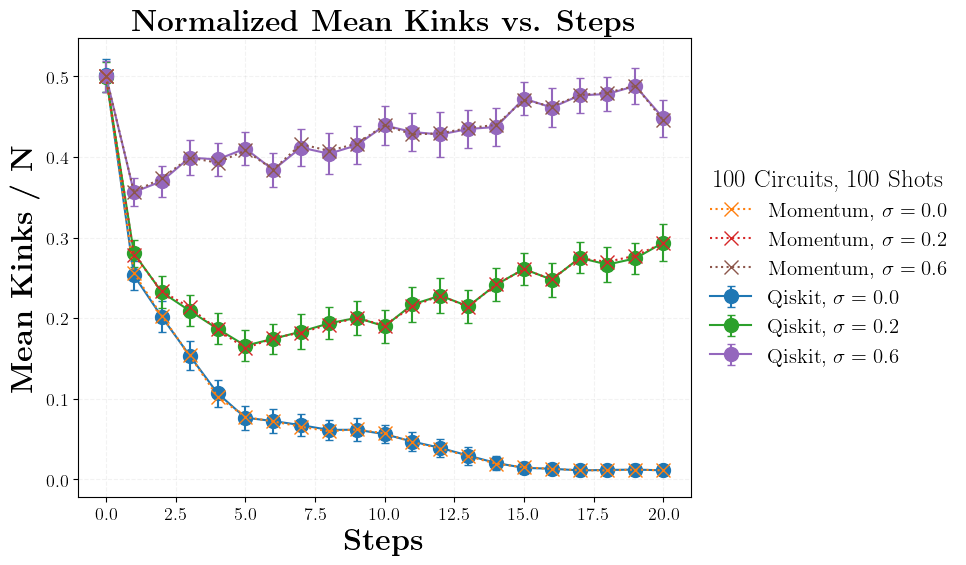

In [119]:
# --- Extract data for Graph 1 ---
g1_data = all_data['graph1_2']
results = g1_data['results']
params = g1_data['params']
steps_list = params['steps_list']
noise_params_list = params['noise_params_list']

# --- Plotting ---
pyplot_settings()
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

x = np.array(steps_list)
for n in noise_params_list:
    # Extract mean and std values for Qiskit and the momentum model
    mean_q_mean = np.array([results[n][i]['qiskit_mean_kinks_r_mean'] for i in x])
    mean_q_std_err = np.array([results[n][i]['qiskit_mean_kinks_r_std_err'] for i in x])
    mean_m = np.array([results[n][i]['mean_independent_modes'] for i in x])

    # Plot lines with error bars for Qiskit, and a simple line for the momentum model
    ax.errorbar(x, mean_q_mean, yerr=mean_q_std_err, fmt='o-', capsize=3, label=f'Qiskit, $\\sigma={n}$', zorder=1)
    ax.plot(x, mean_m, 'x:', label=f'Momentum, $\\sigma={n}$', zorder=2)

ax.set_xlabel(r'\textbf{Steps}')
ax.set_ylabel(r'\textbf{Mean Kinks / N}')
ax.set_title(r'\textbf{Normalized Mean Kinks vs. Steps}')
ax.grid(True)
legend_title = f"{params['num_circuits']} Circuits, {params['num_shots']} Shots"
ax.legend(title=legend_title, loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout(rect=[0, 0, 1.25, 1])
# plot_filename = get_dated_plot_path(f"Mean_kinks_vs_steps.svg")
# plt.savefig(plot_filename, bbox_inches='tight')
plt.show()


## Graph 2: Normalized Variance of Number of Kinks vs Steps

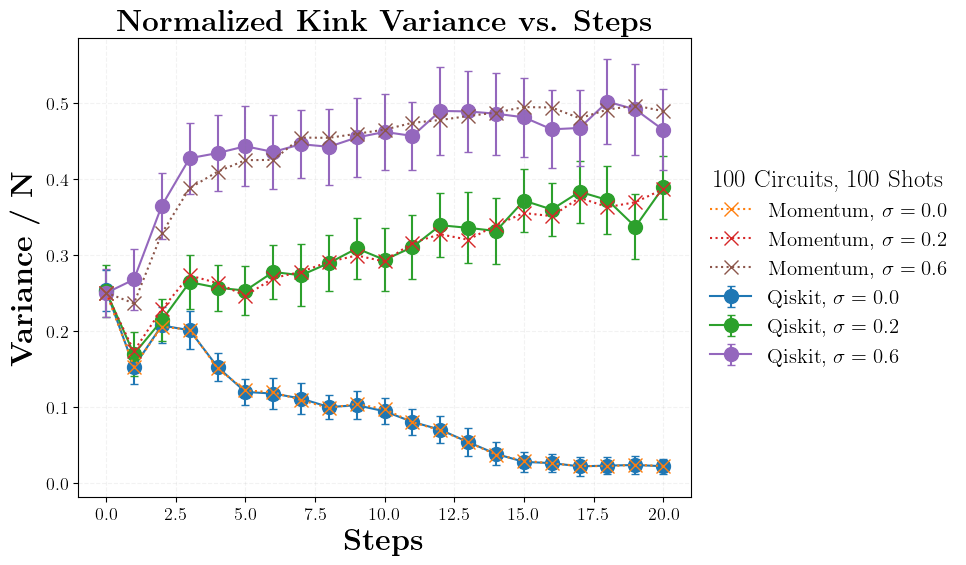

In [120]:
# --- Extract data for Graph 2 ---
g2_data = all_data['graph1_2']
results = g2_data['results']
params = g2_data['params']
steps_list = params['steps_list']
noise_params_list = params['noise_params_list']

# --- Plotting ---
pyplot_settings()
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

x = np.array(steps_list)
for n in noise_params_list:
    # Extract variance values for Qiskit and the momentum model
    var_q_mean = np.array([results[n][i]['qiskit_var_kinks_r_mean'] for i in x])
    var_q_std_err = np.array([results[n][i]['qiskit_var_kinks_r_std_err'] for i in x])
    var_m = np.array([results[n][i]['var_independent_modes'] for i in x])

    # Plot lines for each noise parameter (with error bars for Qiskit variance)
    ax.errorbar(x, var_q_mean, yerr=var_q_std_err, fmt='o-', capsize=3, label=f'Qiskit, $\\sigma={n}$', zorder=1)
    ax.plot(x, var_m, 'x:', label=f'Momentum, $\\sigma={n}$', zorder=2)

ax.set_xlabel(r'\textbf{Steps}')
ax.set_ylabel(r'\textbf{Variance / N}')
ax.set_title(r'\textbf{Normalized Kink Variance vs. Steps}')
ax.grid(True)
legend_title = f"{params['num_circuits']} Circuits, {params['num_shots']} Shots"
ax.legend(title=legend_title, loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout(rect=[0, 0, 1.25, 1])
# plot_filename = get_dated_plot_path(f"Variance_kinks_vs_steps.svg")
# plt.savefig(plot_filename, bbox_inches='tight')
plt.show()

## Graph 3: Ratio of Variance to Mean vs. Noise

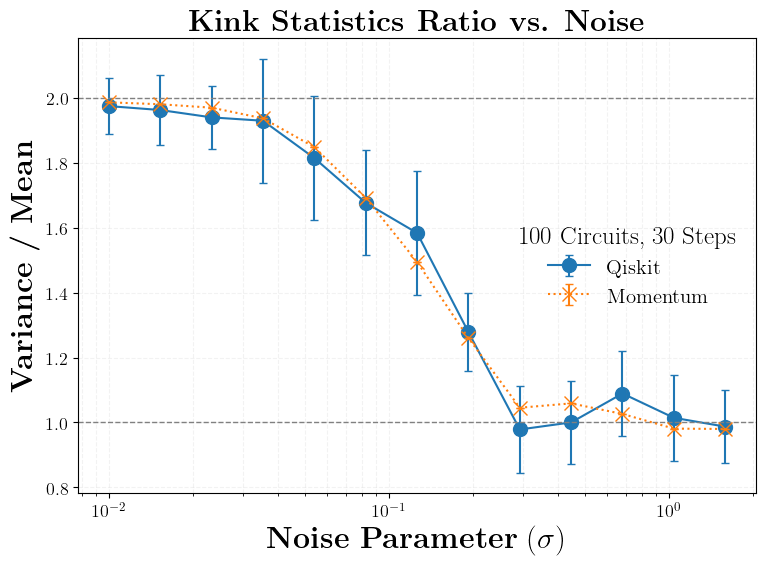

In [145]:
pyplot_settings()
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
graph_data = all_data['graph3']
p = graph_data['params']
results = graph_data['results']
x = np.array(p['noise_params_list'])

ratio_q_mean = [results[n]['qiskit_ratio_mean'] for n in x]
ratio_q_std = [results[n]['qiskit_ratio_std'] for n in x]
ratio_m_mean = [results[n]['momentum_ratio_mean'] for n in x]
ratio_m_std = [results[n]['momentum_ratio_std'] for n in x]

ax.errorbar(x, ratio_q_mean, yerr=ratio_q_std, fmt='o-', capsize=3, label='Qiskit', zorder=1)
ax.errorbar(x, ratio_m_mean, yerr=ratio_m_std, fmt='x:', capsize=3, label='Momentum', zorder=2)

ax.set_xscale('log')
ax.axhline(1.0, color='gray', linestyle='--', linewidth=1)
ax.axhline(2.0, color='gray', linestyle='--', linewidth=1)

ax.set_xlabel(r'\textbf{Noise Parameter} ($\sigma$)')
ax.set_ylabel(r'\textbf{Variance / Mean}')
ax.set_title(r'\textbf{Kink Statistics Ratio vs. Noise}')
ax.grid(True)
legend_title = f"{params['num_circuits']} Circuits, {p['steps']} Steps"
ax.legend(title=legend_title)

plt.tight_layout(rect=[0, 0, 1, 1])
# plot_filename = get_dated_plot_path(f"Ratio_vs_noise_N{NUM_QUBITS}.svg")
# plt.savefig(plot_filename, bbox_inches='tight')
plt.show()

## Graph 4: Model Difference vs. Number of Circuits

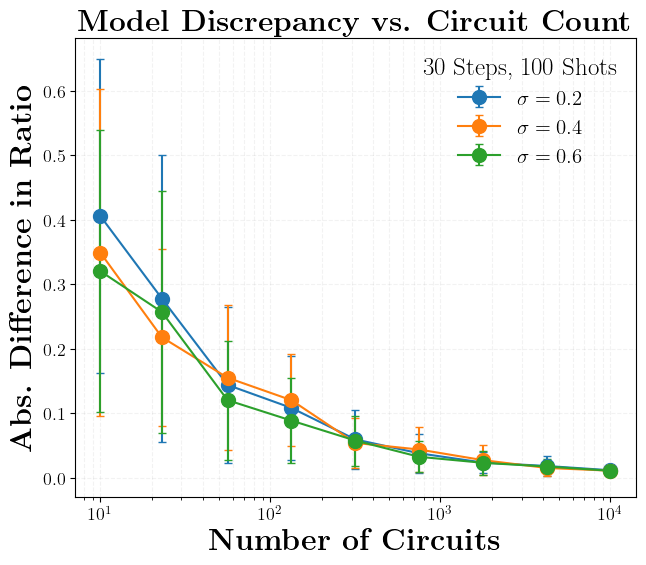

In [163]:
pyplot_settings()
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
graph_data = all_data['graph4']
p = graph_data['params']
results = graph_data['results']
x = np.array(p['num_circuits_list'])

for noise_param in p['noise_params_list']:
    y_mean = [results[nc][noise_param]['diff_mean'] for nc in x]
    y_std = [results[nc][noise_param]['diff_std'] for nc in x]
    ax.errorbar(x, y_mean, yerr=y_std, fmt='o-', capsize=3, label=f'$\\sigma={noise_param}$')

ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlabel(r'\textbf{Number of Circuits}')
ax.set_ylabel(r'\textbf{Abs. Difference in Ratio}')
ax.set_title(r'\textbf{Model Discrepancy vs. Circuit Count}')
ax.grid(True)
legend_title = f"{p['num_qubits']}Qubits, {p['steps']} Steps, {p['num_shots']} Shots "
ax.legend(title=legend_title)

plt.tight_layout(rect=[0, 0, 0.85, 1])
# plot_filename = get_dated_plot_path(f"Diff_vs_circs_N{NUM_QUBITS}.svg")
# plt.savefig(plot_filename, bbox_inches='tight')
plt.show()


## Graph 5: Difference with Fake Backend vs. Number of Circuits

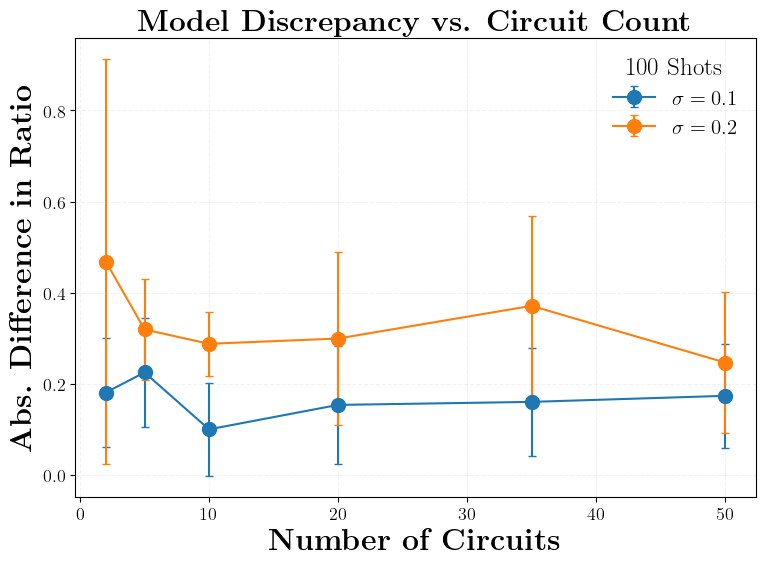

In [190]:
pyplot_settings()
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
graph_data = all_data['graph5']
p = graph_data['params']
results = graph_data['results']
x = np.array(p['num_circuits_list'])

for noise_param in p['noise_params_list']:
    y_mean = [results[nc][noise_param]['diff_mean'] for nc in x]
    y_std = [results[nc][noise_param]['diff_std'] for nc in x]
    ax.errorbar(x, y_mean, yerr=y_std, fmt='o-', capsize=3, label=f'$\\sigma={noise_param}$')

# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlabel(r'\textbf{Number of Circuits}')
ax.set_ylabel(r'\textbf{Abs. Difference in Ratio}')
ax.set_title(r'\textbf{Model Discrepancy vs. Circuit Count}')
ax.grid(True)
legend_title = f"{p['num_shots']} Shots"
ax.legend(title=legend_title)

plt.tight_layout()
# plot_filename = get_dated_plot_path(f"Diff_vs_circs_fake_backend_N{NUM_QUBITS}.svg")
# plt.savefig(plot_filename, bbox_inches='tight')
plt.show()

# Legacy Code (Old calculation and plotting cells)

## Graph 2: Normalized Variance of Number of Kinks vs Steps


In [ ]:
from collections import defaultdict
from typing import List, Optional

import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from tqdm import tqdm

from discrete_numeric import get_dated_plot_path, tfim_momentum_trotter_single_k, count_kinks, process_step
from functions import k_f, pyplot_settings

num_qubits: int = 6
steps_list: List[int] = [i for i in range(21)]
num_circuits: int = 100
noise_params_list: List[float] = [0.0, 0.2, 0.6]
num_shots: int = 10000
plot_filename: Optional[str] = None
if plot_filename is None:
    plot_filename = get_dated_plot_path(
            f"Mean_kinks_N{num_qubits}_steps{steps_list}_circ{num_circuits}_noise{noise_params_list}_numshots{num_shots}.svg"
            )
ks = k_f(num_qubits)
results = defaultdict(dict)
for noise_param in tqdm(noise_params_list, desc="Processing noise parameters"):
    for steps in tqdm(steps_list):
        base_angles = (np.pi / 2) * np.arange(1, steps + 1) / (steps + 1)
        base_angles = base_angles[:, np.newaxis]
        momentum_dms = []
        qiskit_results_list = []
        for _ in tqdm(range(num_circuits)):
            noisy_base = base_angles + noise_param * np.random.randn(steps, 1)
            betas = -np.sin(noisy_base).flatten()  # -np.sin(base_angles).flatten()
            alphas = -np.cos(noisy_base).flatten()
            sol = [tfim_momentum_trotter_single_k(k, steps, betas, alphas, 0) for k in ks]
            momentum_dms.append(sol)
            circuit = QuantumCircuit(num_qubits, num_qubits)
            circuit.h(range(num_qubits))  # Initial superposition
            for step in range(steps):
                beta = betas[step]
                alpha = alphas[step]
                for i in range(0, num_qubits, 2):
                    j = (i + 1) % num_qubits
                    circuit.rzz(beta, i, j)
                for i in range(1, num_qubits, 2):
                    j = (i + 1) % num_qubits
                    circuit.rzz(beta, i, j)
                for i in range(num_qubits):
                    circuit.rx(alpha, i)
            circuit.measure(range(num_qubits), range(num_qubits))
            simulator = AerSimulator()
            transpiled_circuits = transpile(circuit, simulator, num_processes=-1)
            job_result = simulator.run(transpiled_circuits, shots=num_shots).result()
            qiskit_results_list.append({'counts': job_result.get_counts(),})
        total_counts = {}
        for result in qiskit_results_list:
            counts = result['counts']  # Access counts from our dictionary
            for state, count in counts.items():
                total_counts[state] = total_counts.get(state, 0) + count
        total_shots = sum(total_counts.values())
        probabilities = {state: count / total_shots for state, count in total_counts.items()}
        kink_counts = [count_kinks(state) for state in probabilities.keys()]
        mean_kinks0 = sum(k * p for k, p in zip(kink_counts, probabilities.values()))
        var_kinks0 = sum((k - mean_kinks0) ** 2 * p for k, p in zip(kink_counts, probabilities.values()))

        var_r = var_kinks0 / num_qubits
        mean_i, var_i = process_step(step_density_matrices=momentum_dms, ks=ks, num_qubits=num_qubits, method="rho")

        results[noise_param][steps] = {
            'var_independent_modes'           : var_i,
            'qiskit_var_kinks_r'              : var_r,
            }
pyplot_settings()
fig, ax = plt.subplots(1, 1, figsize=(7, 6))

x = np.array(steps_list)
for n in noise_params_list:
    mean_qiskit = np.array([results[n][i]['qiskit_var_kinks_r'] for i in x])
    mean_independent = np.array([results[n][i]['var_independent_modes'] for i in x])
    # plot lines
    ax.plot(x, mean_qiskit, 'o-', label='Qiskit noise={:.3f}'.format(n))
    ax.plot(x, mean_independent, 'x:', label='Independent Modes (rho averaging) noise={:.3f}'.format(n))

ax.set_xlabel(r'\textbf{Steps}')
ax.set_ylabel(r'\textbf{Variance/Qubits}')
ax.grid(True)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# # add title
# super_title = (rf"qubits = {num_qubits}, "
#                rf"steps = {steps}, "
#                rf"circuits = {num_circuits}")
# plt.suptitle(super_title, y=0.94)

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.savefig(plot_filename, bbox_inches='tight')
plt.show()


# Graph 3: Ratio of Variance to Average Number of Kinks vs Noise

In [ ]:
num_qubits: int = 6
steps: int = 30
num_circuits: int = 100
noise_params_list: List[float] = np.logspace(-2.5, 1.5, 8).tolist()
num_shots: int = 10000
plot_filename: Optional[str] = None
"""
Compare Qiskit results with momentum model for given parameters.
"""
if plot_filename is None:
    plot_filename = get_dated_plot_path(
            f"qiskit_vs_momentum_N{num_qubits}_steps{steps}_circ{num_circuits}.svg"
            )
results = {}
ks = k_f(num_qubits)
base_angles = (np.pi / 2) * np.arange(1, steps + 1) / (steps + 1)
base_angles = base_angles[:, np.newaxis]
for noise_param in tqdm(noise_params_list, desc="Processing noise parameters"):
    momentum_dms = []
    qiskit_results_list = []
    for _ in range(num_circuits):
        noisy_base = base_angles + noise_param * np.random.randn(steps, 1)
        betas = -np.sin(noisy_base).flatten()  # -np.sin(base_angles).flatten()
        alphas = -np.cos(noisy_base).flatten()
        sol = [tfim_momentum_trotter_single_k(k, steps, betas, alphas, 0) for k in ks]
        momentum_dms.append(sol)
        circuit = QuantumCircuit(num_qubits, num_qubits)
        circuit.h(range(num_qubits))  # Initial superposition
        for step in range(steps):
            beta = betas[step]
            alpha = alphas[step]
            for i in range(0, num_qubits, 2):
                j = (i + 1) % num_qubits
                circuit.rzz(beta, i, j)
            for i in range(1, num_qubits, 2):
                j = (i + 1) % num_qubits
                circuit.rzz(beta, i, j)
            for i in range(num_qubits):
                circuit.rx(alpha, i)
        circuit.measure(range(num_qubits), range(num_qubits))
        simulator = AerSimulator()
        transpiled_circuits = transpile(circuit, simulator, num_processes=-1)
        job_result = simulator.run(transpiled_circuits, shots=num_shots).result()
        qiskit_results_list.append({
            'counts': job_result.get_counts(),
            })
    total_counts = {}
    for result in qiskit_results_list:
        counts = result['counts']  # Access counts from our dictionary
        for state, count in counts.items():
            total_counts[state] = total_counts.get(state, 0) + count
    total_shots = sum(total_counts.values())
    probabilities = {state: count / total_shots for state, count in total_counts.items()}
    kink_counts = [count_kinks(state) for state in probabilities.keys()]
    mean_kinks0 = sum(k * p for k, p in zip(kink_counts, probabilities.values()))
    var_kinks0 = sum((k - mean_kinks0) ** 2 * p for k, p in zip(kink_counts, probabilities.values()))
    ratio_r = var_kinks0 / mean_kinks0
    mean_i, var_i = process_step(step_density_matrices=momentum_dms, ks=ks, num_qubits=num_qubits, method="rho")
    ratio_i = var_i / mean_i

    results[noise_param] = {
        'momentum_ratio_independent_modes': ratio_i,
        'qiskit_ratio_r'                  : ratio_r,
        }


In [ ]:
pyplot_settings()
fig, ax = plt.subplots(1, 1, figsize=(7, 6))

x = np.array(noise_params_list)
ratio_inde = np.array([results[n]['momentum_ratio_independent_modes'] for n in x])
ratio_qiskit = np.array([results[n]['qiskit_ratio_r'] for n in x])
# plot lines
ax.plot(x, ratio_inde, 'o-', label=f'Momentum N={num_qubits}')
ax.plot(x, ratio_qiskit, 'x:', label=f'Qiskit N={num_qubits}')

ax.set_xscale('log')
ax.axhline(2 , color='gray', linestyle='--', linewidth=1)
ax.axhline(1, color='gray', linestyle='--', linewidth=1)

ax.set_xlabel(r'\textbf{Noise Parameter}')
ax.set_ylabel(r'\textbf{Variance/Mean}')
ax.set_title(r'\textbf{Kink Statistics Ratio vs. Noise}')
ax.grid(True)
legend_title = f"C={num_circuits}, S={num_shots}"
ax.legend(title=legend_title, loc='center left', bbox_to_anchor=(1, 0.5))

# add title
super_title = (rf"qubits = {num_qubits}, "
               rf"steps = {steps}, "
               rf"circuits = {num_circuits}")
plt.suptitle(super_title, y=0.94)

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.savefig(plot_filename, bbox_inches='tight')
plt.show()

# Graph 4: Independent Modes vs Qiskit with Varying Shots

In [ ]:
num_qubits: int = 6
steps: int = 30
num_circuits_list: List[int] = [int(i) for i in np.logspace(1, 4, 5)]
noise_params_list: List[float] = [0.2, 0.6]
num_shots: int = 10000
ks = k_f(num_qubits)

base_angles = (np.pi / 2) * np.arange(1, steps + 1) / (steps + 1)
base_angles = base_angles[:, np.newaxis]
results = {}
for num_circuits in tqdm(num_circuits_list, desc="Processing number of circuits"):
    results[num_circuits] = {}
    for noise_param in tqdm(noise_params_list, desc="Processing noise parameters"):
        momentum_dms = []
        qiskit_results_list = []
        for _ in range(num_circuits):
            noisy_base = base_angles + noise_param * np.random.randn(steps, 1)
            betas = -np.sin(noisy_base).flatten()  # -np.sin(base_angles).flatten()
            alphas = -np.cos(noisy_base).flatten()
            sol = [tfim_momentum_trotter_single_k(k, steps, betas, alphas, 0) for k in ks]
            momentum_dms.append(sol)
            circuit = QuantumCircuit(num_qubits, num_qubits)
            circuit.h(range(num_qubits))  # Initial superposition
            for step in range(steps):
                beta = betas[step]
                alpha = alphas[step]
                for i in range(0, num_qubits, 2):
                    j = (i + 1) % num_qubits
                    circuit.rzz(beta, i, j)
                for i in range(1, num_qubits, 2):
                    j = (i + 1) % num_qubits
                    circuit.rzz(beta, i, j)
                for i in range(num_qubits):
                    circuit.rx(alpha, i)
            circuit.measure(range(num_qubits), range(num_qubits))
            simulator = AerSimulator()
            transpiled_circuits = transpile(circuit, simulator, num_processes=-1)
            job_result = simulator.run(transpiled_circuits, shots=num_shots).result()
            qiskit_results_list.append({
                'counts': job_result.get_counts(),
                })
        total_counts = {}
        for result in qiskit_results_list:
            counts = result['counts']  # Access counts from our dictionary
            for state, count in counts.items():
                total_counts[state] = total_counts.get(state, 0) + count
        total_shots = sum(total_counts.values())
        probabilities = {state: count / total_shots for state, count in total_counts.items()}
        kink_counts = [count_kinks(state) for state in probabilities.keys()]
        mean_kinks0 = sum(k * p for k, p in zip(kink_counts, probabilities.values()))
        var_kinks0 = sum((k - mean_kinks0) ** 2 * p for k, p in zip(kink_counts, probabilities.values()))
        ratio_r = var_kinks0 / mean_kinks0 if mean_kinks0 != 0 else 0

        mean_i, var_i = process_step(step_density_matrices=momentum_dms, ks=ks, num_qubits=num_qubits, method="rho")
        ratio_i = var_i / mean_i if mean_i != 0 else 0

        results[num_circuits][noise_param] = {
            'momentum_ratio_independent_modes': ratio_i,
            'qiskit_ratio_r'                  : ratio_r,
            }

In [ ]:
pyplot_settings()
fig, ax = plt.subplots(1, 1, figsize=(7, 6))

x = np.array(num_circuits_list)

for noise_param in noise_params_list[:2]:  # Skip the first noise parameter for clarity
    y = np.array([np.abs(results[nc][noise_param]['momentum_ratio_independent_modes'] -
                                      results[nc][noise_param]['qiskit_ratio_r']) for nc in x])
    # plot lines
    ax.plot(x, y, 'o-', label=f'noise={noise_param:.3f}')
# plot lines
ax.plot(x, y)

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel(r'\textbf{Number of Circuits}')
ax.set_ylabel(r'\textbf{Difference}')
ax.grid(True)

# # add title
# super_title = (rf"qubits = {num_qubits}, "
#                rf"steps = {steps}, ")
# plt.suptitle(super_title, y=0.94)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

# Graph 5: Independent Modes vs Qiskit with Built-in Fake Noises

In [ ]:
num_qubits: int = 6
steps: int = 30
num_circuits_list: List[int] = [int(i) for i in np.logspace(1, 4, 5)]
noise_params_list: List[float] = [1]
num_shots: int = 10000
ks = k_f(num_qubits)

base_angles = (np.pi / 2) * np.arange(1, steps + 1) / (steps + 1)
base_angles = base_angles[:, np.newaxis]
results = {}
for num_circuits in tqdm(num_circuits_list, desc="Processing number of circuits"):
    results[num_circuits] = {}
    for noise_param in tqdm(noise_params_list, desc="Processing noise parameters"):
        momentum_dms = []
        qiskit_results_list = []
        for _ in range(num_circuits):
            noisy_base = base_angles + noise_param * np.random.randn(steps, 1)
            noisy_betas = -np.sin(noisy_base).flatten()  # -np.sin(base_angles).flatten()
            noisy_alphas = -np.cos(noisy_base).flatten()
            sol = [tfim_momentum_trotter_single_k(k, steps, noisy_betas, noisy_alphas, 0) for k in ks]
            momentum_dms.append(sol)

            alphas = -np.cos(base_angles).flatten()
            betas = -np.sin(base_angles).flatten()
            circuit = QuantumCircuit(num_qubits, num_qubits)
            circuit.h(range(num_qubits))  # Initial superposition
            for step in range(steps):
                beta = betas[step]
                alpha = alphas[step]
                for i in range(0, num_qubits, 2):
                    j = (i + 1) % num_qubits
                    circuit.rzz(beta, i, j)
                for i in range(1, num_qubits, 2):
                    j = (i + 1) % num_qubits
                    circuit.rzz(beta, i, j)
                for i in range(num_qubits):
                    circuit.rx(alpha, i)
            circuit.measure(range(num_qubits), range(num_qubits))
            backend = FakeMarrakesh()
            transpiled_circuit = transpile(circuit, backend, num_processes=-1)
            sampler = SamplerV2(backend)
            job = sampler.run([transpiled_circuit], shots=num_shots)
            pub_result = job.result()[0]
            qiskit_results_list.append({
                'counts': pub_result.data.c.get_counts(),
                })
        total_counts = {}
        for result in qiskit_results_list:
            counts = result['counts']  # Access counts from our dictionary
            for state, count in counts.items():
                total_counts[state] = total_counts.get(state, 0) + count
        total_shots = sum(total_counts.values())
        probabilities = {state: count / total_shots for state, count in total_counts.items()}
        kink_counts = [count_kinks(state) for state in probabilities.keys()]
        mean_kinks = sum(k * p for k, p in zip(kink_counts, probabilities.values()))
        var_kinks = sum((k - mean_kinks) ** 2 * p for k, p in zip(kink_counts, probabilities.values()))
        ratio_r = var_kinks / mean_kinks if mean_kinks != 0 else 0

        mean_i, var_i = process_step(step_density_matrices=momentum_dms, ks=ks, num_qubits=g5_params['num_qubits'], method="rho")
        ratio_i = var_i / mean_i if mean_i != 0 else 0

        results[num_circuits][noise_param] = {'momentum_ratio_independent_modes': ratio_i, 'qiskit_ratio_r': ratio_r}

In [ ]:
pyplot_settings()
fig, ax = plt.subplots(1, 1, figsize=(7, 6))

x = np.array(num_circuits_list)

for noise_param in noise_params_list:
    y = np.array([np.abs(results[nc][noise_param]['momentum_ratio_independent_modes'] -
                                      results[nc][noise_param]['qiskit_ratio_r']) for nc in x])
    # plot lines
    ax.plot(x, y, 'o-', label=f'noise={noise_param:.3f}')
# plot lines
ax.plot(x, y)

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel(r'\textbf{Number of Circuits}')
ax.set_ylabel(r'\textbf{Difference}')
ax.grid(True)

# # add title
# super_title = (rf"qubits = {num_qubits}, "
#                rf"steps = {steps}, ")
# plt.suptitle(super_title, y=0.94)

plt.tight_layout()
plt.show()
